# 분류 성능 평가 지표
 * 정확도(Accuracy)
 * 오차행렬(Confusion Matrix)
 * 정밀도(Precision)
 * 재현율(Recall)
 * F1 스코어
 * ROC AUC
 
### 평가 지표 측정 위해 사용하는 모듈 및 메소드 정리
* accuracy_score(y_test, pred) : 정확도
* confusion_matrix(y_test, pred) : 오차행렬
* precision_score(y_test, pred) : 정밀도
* recall_score(y_test, pred) : 재현율
* predict_proba(X_test) : 예측 확률 값을 반환, 학습이 완료된 객체에 적용하며 반환값은 1열이 0일 확률, 2열이 1일 확률
* Binarizer(threshold = 임곗값) : 임곗값 조정한 객체 생성
 * binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1), 즉 ndarray 값 입력) : 임곗값 조정된 객체에 fit_transform() 함수를 적용시키면 예측값 반환
* precision_recall_curve(y_test, predict_prob[:, 1]) : 임곗값(임의 지정됨)에 따른 정밀도-재현율 값 추출
 * precisions, recalls, thresholds = precision_recall_curve(y_test, predict_proba[:, 1])으로 정확도, 재현율, 임곗값 반환
* f1_score(y_test, predict) : F1 스코어
* roc_curve(y_test, pred_proba[:, 1]) : ROC 곡선
 * fprs, tprs, thresholds = roc_curve(y_test, pred_proba[:, 1]) : precision_recall_curve()와 비슷하게 작동
* roc_auc_score(y_test, pred_proba[:, 1]) : AUC 값


# 정확도
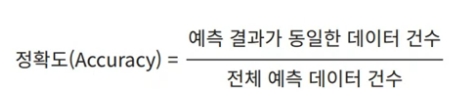<br>
* 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표. 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않음.
 * (ex) 타이타닉 예제 : 예측 정확도 약 80%, 탑승객이 남자인 경우보다 여자인 경우 생존 확률이 높았기 때문에 별다른 알고리즘의 적용 없이 무조건 성별이 여자인 경우 생존, 남자인 경우 사망으로 예측해도 이와 비슷한 수치가 나옴
* 특히, 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.

* MyDummyClassifier 클래스(남자 -> 사망 / 여자 -> 생존)를 이용해 타이타닉 생존자 예측 수행

In [46]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator): # BaseEstimator를 상속받음
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y = None): # y에 None을 지정하면 y에 아무것도 넣지 않을 시 None이 된다는 의미
        pass
    
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    # 즉, 피처가 1(남자)이면 0(사망), 피처가 0(여자)이면 1(생존)
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df
    
# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터 / 테스트데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df) # 피처에 데이터 전처리 함수 적용
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2, random_state = 0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions = myclf.predict(X_test)

print('Dummy Classifier의 정확도는 : {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는 : 0.7877


=> 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 약 78.77%로 꽤 높은 수치가 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신중해야 함

* MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 시 어떤 문제가 발생하는지 살펴봄
* MNIST 데이터 세트는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit를 예측하는데 사용됨
* 원래 MNIST 데이터 세트는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것
* 이것을 레이블 값이 7이면 True, 아니면 False로 변환해 이진 분류 문제로 바꿔봄
* 즉, 전체 데이터의 10%만 True, 나머지는 False인 불균형한 데이터 세트로 변형
* 이를 모두 False(0)으로 예측하는 classifier을 이용해 정확도를 측정하면 90%에 가까운 예측 정확도를 나타냄
* 즉, 아무것도 하지 않고 특정 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있다는 것이 정확도 평가 지표의 맹점

In [50]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    # 무엇이 들어오는지 관계없이 예측 결과값을 False(0)으로 함
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print('### digits.data.shape :', digits.data.shape, '\n')
print(digits.target)
print('### digits.target,shape :', digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape : (1797, 64) 

[0 1 2 ... 8 9 8]
### digits.target,shape : (1797,)


In [51]:
# digits 번호가 7번이면 True이고, 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [52]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape, '\n')
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts(), '\n')

# Dummy Classifier로 학습 / 예측 / 정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : {:.3f}'.format(accuracy_score(y_test, fakepred)))

# 정확도는 양날의 검이 될 수 있으므로 주로 잘 사용하지 않는다 !

레이블 테스트 세트 크기 : (450,) 

테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64 

모든 예측을 0으로 하여도 정확도는 : 0.900


# 오차행렬(Confusion Matrix)
* 오차 행렬은 이진 분류의 예측 오류가 얼마인지와 더불어 `어떠한 유형의 예측 오류`가 발생하고 있는지를 함께 나타내는 지표<br>
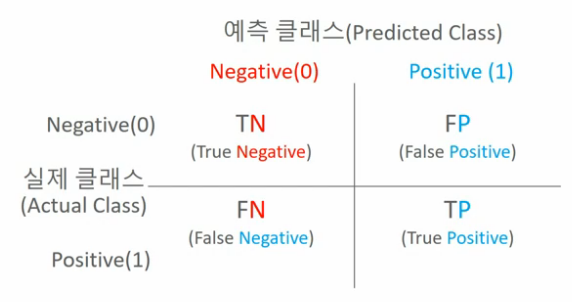<br>



In [12]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

=> TP는 0임. Positive로 예측이 한 건도 성공하지 않음.<br>
=> 이와 더불어 FP가 0이므로 Positive로 예측 자체를 수행하지 않음을 알 수 있음.

# 정밀도(Precision)와 재현율(Recall)<br>
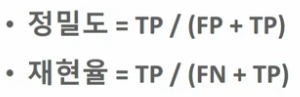<br>
* 정밀도는 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
* 재현율은 실제값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
 * 두 지표 모두 TP는 높고, FP, FN이 낮을수록 좋음
* 정밀도는 precision_score(), 재현율은 recall_score() 제공

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("정밀도 :", precision_score(y_test, fakepred))
print("재현율 :", recall_score(y_test, fakepred))

정밀도 : 0.0
재현율 : 0.0


C:\Users\gram\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=> TP가 0이기 때문에 정밀도와 재현율 모두 0으로 나옴.<br>
=> 따라서, 정확도의 모순을 잡아낼 수 있음

* 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:0.4f}, 정밀도 : {1:0.4f}, 재현율 : {2:0.4f}'.format(accuracy, precision, recall))

* 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고, 예측 평가를 수행

In [55]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore') # warnings 라이브러리를 이용해 경고 메시지를 숨김

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터 / 테스트데이터로 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df) # 데이터 전처리 함수 적용

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


## 정밀도 / 재현율 트레이드 오프
* 업무에 따른 재현율과 정밀도의 상대적 중요도
 * 재현율이 상대적으로 더 중요한 지표인 경우는 `실제 Positive(양성)인 데이터 예측을 Negative(음성) [FN]`로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 : 암 진단, 금융사기 판별
 * 정밀도가 상대적으로 더 중요한 지표인 경우는 `실제 Negative(음성)인 데이터 예측을 Positive(양성) [FP]`으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 : 스팸 메일
<br><br>
* 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음
* 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움. 이를 정밀도 / 재현율의 트레이드오프(Trade-off)라고 부름
 * 정밀도와 재현율은 결과적으로 FP, FN에 의해 결정되는데 임곗값을 조정하여 한 쪽 값을 낮추면, 한 쪽은 높아질 수 밖에 없음<br>
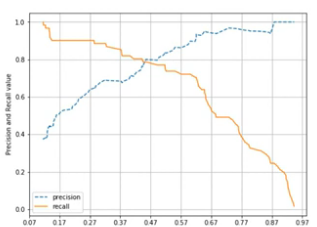<br>
=> x축의 값들이 결정 임곗값, y축의 값들이 정밀도 및 재현율<br><br>

* 분류 결정 임곗값이 낮아질수록 Positive로 예측할 확률이 높아짐. 재현율 증가
 * FN이 작아지기 때문에 (=> 예측을 Negative로 하는 횟수 자체가 작아지기 때문에)
 * 반면에, FP은 예측하는 횟수 자체가 높아지면서 틀릴 확률 자체도 높아지기 때문에 커지므로 정밀도는 감소

* predict_proba() 메소드 : 예측 확률 값을 반환
 * predict()는 예측값을 반환하지만, predict_proba()는 예측 확률값을 반환
 * predict()는 predict_proba()의 1이 될 예측 확률값이 임곗값보다 크면 1, 아니면 0을 반환
 * predict_proba() 메서드는 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하며 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환

In [21]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘풀로 추출 :\n', pred_proba[:3], '\n') # 1열이 0이 될 확률, 2열이 1이 될 확률

# 예측 확률 array와 예측 결과값 array를 concatenate하여 예측 확률과 결과값을 한눈에 확인
# pd.concat() : 데이터프레임 결합
# np.concatenate : 배열 결합
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측 :\n', pred_proba_result[:3])

pred_proba() 결과 shape : (179, 2)
pred_proba array에서 앞 3개만 샘풀로 추출 :
 [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]] 

두 개의 class 중 더 큰 확률을 클래스 값으로 예측 :
 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


* Binarizer 활용 : 임곗값 조정
 * 즉, 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정 가능
 * threshold 변수를 특정 값으로 설정하고 Binarizer 클래스로 객체를 생성
 * 생성된 Binarizer 객체의 fit_transform() 메서드를 이용해 넘파이 ndarray를 입력하면 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0, 크면 1로 변환해 반환

In [23]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0 , 0],
     [0, 1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


* 분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환

In [25]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


=> 이렇게 계산된 평가 지표는 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 같음<br>
=> 기존의 threshold 값도 0.5임을 알 수 있음

* 분류 결정 임계값 0.4 기반에서 Binarizer를 이용하여 예측값 변환

In [26]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉, 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


=> 재현율이 높아지고 정밀도가 낮아짐

* 여러 개의 분류 결정 임곗값을 변경하면서 Binarizer를 이용하여 예측값 변환

In [31]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, threshold):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print()
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값 : 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197

임곗값 : 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869

임곗값 : 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705

임곗값 : 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377

임곗값 : 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213



=> 임곗값이 높아질수록 정밀도는 높아지고, 재현율이 낮아지는 것을 알 수 있음

* precision_recall_curve()를 이용하여 임곗값에 따른 정밀도-재현율 값 추출
 * 입력 파라미터 : y_true(실제 클래스 값 배열), pred_proba(Positive 칼럼의 예측 확률 배열)
 * 반환값 : 정밀도, 재현율, 임곗값

In [33]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
# precision_recall_curve는 여러 임계값에 따른 정밀도, 재현율을 반환해줌
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape :', thresholds.shape)
print('반환된 precisions 배열의 Shape :', precisions.shape)
print('반환된 recalls 배열의 Shape :', recalls.shape)

print('thresholds 5 sample :', thresholds[:5])
print('precisions 5 sample :', precisions[:5])
print('recalls 5 sample :', recalls[:5])

# 반환된 임계값 배열 로우가 147건 -> 너무 작은 값 단위로 많이 구성되어 있음
# 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 :', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 :', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape : (147,)
반환된 precisions 배열의 Shape : (148,)
반환된 recalls 배열의 Shape : (148,)
thresholds 5 sample : [0.11573101 0.11636721 0.11819211 0.12102773 0.12349478]
precisions 5 sample : [0.37888199 0.375      0.37735849 0.37974684 0.38216561]
recalls 5 sample : [1.         0.98360656 0.98360656 0.98360656 0.98360656]
샘플 추출을 위한 임계값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 : [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도 : [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율 : [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


* 임곗값 변경에 따른 정밀도-재현율 변화 곡선을 그림

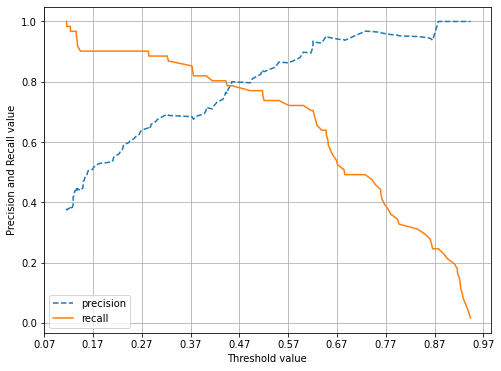

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X축의 Scale을 0, 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2)) # xticks()는 x축의 눈금 표시
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## 정밀도와 재현율의 맹점
* 정밀도를 100%로 만드는 법
 * 확실한 기준이 되는 경우만 Positive로 예측하고, 나머지는 모두 Negative로 예측, 정밀도 = TP / (TP + FP)임. 전체 환자 1000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 하면 이 한 명만 Positive로 예측하고 나머지는 모두 Negative로 예측하더라도 FP는 0, TP는 1이 되므로 정밀도는 100%가 됨
* 재현율을 100%로 만드는 법
 * 모든 환자를 Positive로 예측, 재현율 = TP / (TP + FN)이므로 전체 환자 1000명을 다 Positive로 예측, 이 중 실제 양성인 사람이 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 재현율이 100%가 됨<br>
 
=> 정밀도와 재현율 성능 수치도 어느 한 쪽만 참고하면 극단적인 수치 조작이 가능<br>
=> 따라서, 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주

# F1 스코어 (F1 Score)
* F1 스코어는 정밀도와 재현율을 결합한 지표, F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐<br>
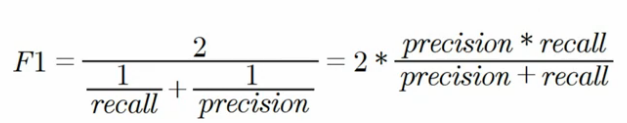<br>
* 사이킷런은 f1 score를 위해 f1_score() 함수를 제공

In [38]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7966


In [39]:
# get_clf_eval() 함수에 F1 스코어 추가

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)

임곗값 : 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197, F1 : 0.7576

임곗값 : 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869, F1 : 0.7869

임곗값 : 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705, F1 : 0.7966

임곗값 : 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377, F1 : 0.7965

임곗값 : 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213, F1 : 0.8000



# ROC 곡선과 AUC
* ROC 곡선(Receiver Operation Characteristic Curve)과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표, 일반적으로 의학 분야에서 많이 사용되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표<br>
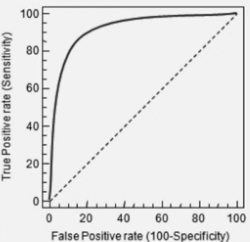<br>
* FPR이 변할 때 TPR이 어떻게 변하는지를 나타낸 곡선이 `ROC 곡선`
* TPR은 True Positive Rate의 약자이며, 이는 재현율을 나타냄, 따라서 TPR은 TP / (FN + TP)임, 즉, 재현율은 민감도라고도 불림
 * 민감도에 대응하는 지표인 TNR, 특이성은 실제값 Negative(음성)이 정확히 예측되야 하는 수준 
* FPR은 실제 Negative(음성)을 잘못 예측한 비율, 즉, 실제는 Negative인데 Positive로 잘못 예측한 비율, FPR = FP / (FP + TN)이다.
* 가운데 직선은 ROC 곡선의 최저값 -> TPR이 떨어지는 속도와 FPR이 떨어지는 속도가 같음
* ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구함 -> 앞에서 배운 분류 결정 임곗값을 변경하여 FPR을 변경하면 됨 !
 * 즉, `오른쪽 위 꼭짓점에서 시작`(FPR, TPR 둘다 1, 임계값은 0)해서 임계값을 서서히 높여서 FPR을 낮추면서 TPR은 서서히 떨어지는 것이 좋음 => 따라서, 곡선이 완만한 것이 좋음
 * 즉, FPR을 0으로 만들려면 임계값을 1로 지정하면 됨 (Positive 자체를 예측을 안하니까 !) 
* 사이킷런의 `roc_curve()` 이용, 실제 클래스 값과 predict_prob()의 반환값 array에서 Positive 컬럼의 예측 확률 사용

In [41]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# precision_recall_curve()와 비슷하게 작동
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
# threshold[0]은 max(예측확률) + 1로 임의 설정됨, 이를 제외하기 위해 np.arange()는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index :', thr_index)
print('샘플 index로 추출한 임곗값 :', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR :', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR :', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index : [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값 : [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR : [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR : [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


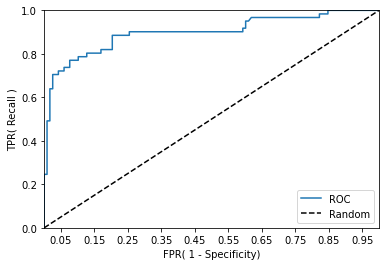

In [47]:
# ROC 곡선 그리기

def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC Curve를 plot곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
    
    # FPR X축의 Scale을 0, 1 단위로 변경, X, Y축명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Specificity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

* 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC(Area Under Curve) 값으로 결정
* AUC 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치
* 사이킷런의 `roc_auc_score()` 이용, 실제 클래스 값과 predict_prob()의 반환값 array에서 Positive 컬럼의 예측 확률 사용

In [48]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8987


In [2]:
# 성능 평가 지표에 AUC 값 추가

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},\
          F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 피마 인디언 당뇨병 예측
피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 지금까지 설명한 평가 지표를 적용<br>
* Pregnancies : 임신 횟수
* Glucose : 포도당 부하 검사 수치
* BloodPressure : 혈압(mm Hg)
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin : 혈청 인슐린(mu U/ml)
* BMI : 체질량지수(체중(kg))/(키(m)^2)
* DiabetesPedigreeFunction : 당뇨 내력 가중치 값
* Age : 나이
* Outcome : 클래스 결정 값 (0 또는 1)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('./diabetes.csv')

# 타겟값인 Outcome 클래스의 분포와 데이터를 개략적으로 확인
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [24]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


=> Null 값은 없으며, 피처의 타입은 모두 숫자형

* 앞 예제에서 사용된 get_clf_eval()과 precision_recall_curve_plot() 재로딩

In [25]:
# 수정된 get_clf_eval() 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    # ROC_AUC print 추가
    print('정확도 : {0:0.4f}, 정밀도 : {1:0.4f}, 재현율 : {2:0.4f}, \
    F1 : {3:0.4f}, AUC : {4:0.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [26]:
# precision_recall_curve 그래프 그리는 함수
def precision_recall_curve_plot(y_test = None, pred_proba_c1 = None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로 Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X축의 Scale을 0, 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

* Logistic Regression으로 학습 및 예측 수행

In [27]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y) # stratify 방식으로 데이터를 분리

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1] # 1일 때의 확률만 가져올 수 있도록 함

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도 : 0.7111, 재현율 : 0.5926,     F1 : 0.6465, AUC : 0.8083


=> 재현율이 높지 못하므로 이를 높이는 방향으로 모델을 향상시켜 나가도록 함

* precision recall 곡선 그림

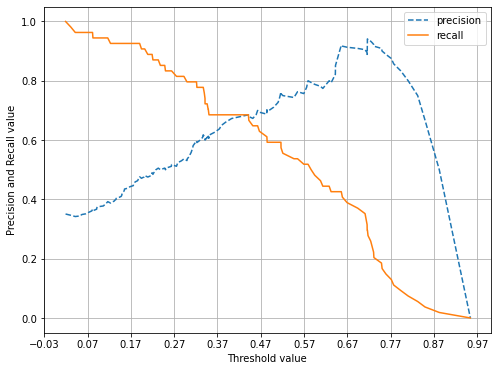

In [28]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

=> 임계값의 최적은 두 곡선이 만나는 0.42 정도 되는 것으로 보임<br>
=> 하지만, 두 개의 지표 모두 0.7이 안 되는 낮은 수치이기 때문에 임곗값을 조작하기 전에 다시 데이터 값을 점검

* 각 피처들의 값 4분위 분포 확인

In [29]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


=> 각 변수의 최솟값이 0임. 이는 데이터에 잘못된 부분이 포함되어 있다는 것을 의미함

* Glucose 피처의 분포도

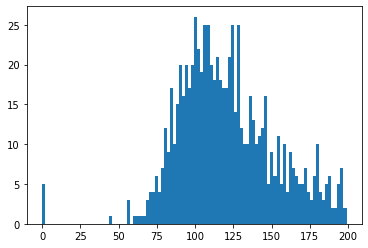

In [30]:
plt.hist(diabetes_data['Glucose'], bins = 100)
plt.show()

=> 데이터의 0값의 빈도가 있는 것을 확인

* 0값이 있는 피처들에서 0값의 데이터 건수와 퍼센트 계산

In [31]:
# 0값을 검사할 피처열 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100 * zero_count / total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


=> SkinThickness와 Insulin의 0값은 전체의 29.56%, 48.7%로 상당히 많음<br>
=> 전체 데이터 수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어려움

* 0값을 평균값으로 대체

In [21]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
# 반복문 사용할 필요없이 한 번에 대체 가능
# replace가 컬럼별로 데이터 대체를 수행
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

* StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용하고 0값을 평균값으로 대체한 데이터 세트로 학습/예측
 * 로지스틱 회귀는 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음

In [33]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,     F1 : 0.6804, AUC : 0.8059


=> 처음 모델보다 성능이 더 좋아진 것을 확인할 수 있음

* 분류결정 임곗값을 변경하면서 성능 측정

In [37]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print()

In [38]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값 : 0.3
오차 행렬
[[68 32]
 [13 41]]
정확도 : 0.7078, 정밀도 : 0.5616, 재현율 : 0.7593,     F1 : 0.6457, AUC : 0.8059

임곗값 : 0.33
오차 행렬
[[74 26]
 [15 39]]
정확도 : 0.7338, 정밀도 : 0.6000, 재현율 : 0.7222,     F1 : 0.6555, AUC : 0.8059

임곗값 : 0.36
오차 행렬
[[76 24]
 [18 36]]
정확도 : 0.7273, 정밀도 : 0.6000, 재현율 : 0.6667,     F1 : 0.6316, AUC : 0.8059

임곗값 : 0.39
오차 행렬
[[79 21]
 [19 35]]
정확도 : 0.7403, 정밀도 : 0.6250, 재현율 : 0.6481,     F1 : 0.6364, AUC : 0.8059

임곗값 : 0.42
오차 행렬
[[81 19]
 [20 34]]
정확도 : 0.7468, 정밀도 : 0.6415, 재현율 : 0.6296,     F1 : 0.6355, AUC : 0.8059

임곗값 : 0.45
오차 행렬
[[85 15]
 [20 34]]
정확도 : 0.7727, 정밀도 : 0.6939, 재현율 : 0.6296,     F1 : 0.6602, AUC : 0.8059

임곗값 : 0.48
오차 행렬
[[88 12]
 [21 33]]
정확도 : 0.7857, 정밀도 : 0.7333, 재현율 : 0.6111,     F1 : 0.6667, AUC : 0.8059

임곗값 : 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,     F1 : 0.6804, AUC : 0.8059



=> threshold가 낮을수록 재현율이 높아지므로, threshold 범위를 0.5에서 멈춤<br>
=> 재현율과 정밀도가 적절히 조화되는 임곗값 0.48을 고려 

In [40]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당되는 컬럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [21 33]]
정확도 : 0.7857, 정밀도 : 0.7333, 재현율 : 0.6111,     F1 : 0.6667, AUC : 0.8059
